<a href="https://colab.research.google.com/github/yierrr/random-nonsense/blob/main/A1_Yier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install mpi4py

In [ ]:
import numpy as np
import scipy.stats as sts
import time

# Question 1a

In [ ]:
%%writefile sim_og.py 
from mpi4py import MPI
import numpy as np
import scipy.stats as sts
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
name = MPI.Get_processor_name()


# Set model parameters
rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu
# Set simulation parameters, draw all idiosyncratic random shocks,
# and create empty containers
S = 1000 # Set the number of lives to simulate
T = int(4160) # Set the number of periods for each simulation
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S)) # error term matrix
z_mat = np.zeros((T, S))

for s_ind in range(S):
    z_tm1 = z_0
    for t_ind in range(T):
        e_t = eps_mat[t_ind, s_ind]
        z_t = rho * z_tm1 + (1 - rho) * mu + e_t
        z_mat[t_ind, s_ind] = z_t
        z_tm1 = z_t


Overwriting sim_og.py


In [ ]:
t1_og = time.time()
! mpirun --allow-run-as-root -n 1 python sim_og.py
t2_og = time.time()
dt_og = t2_og - t1_og
print(dt_og)

9.360298871994019


In [ ]:
rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu
# Set simulation parameters, draw all idiosyncratic random shocks,
# and create empty containers
S = 1000 # Set the number of lives to simulate
T = int(4160) # Set the number of periods for each simulation
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S)) # error term matrix
z_mat = np.zeros((T, S))

for s_ind in range(S):
    z_tm1 = z_0
    for t_ind in range(T):
        e_t = eps_mat[t_ind, s_ind]
        z_t = rho * z_tm1 + (1 - rho) * mu + e_t
        z_mat[t_ind, s_ind] = z_t
        z_tm1 = z_t

In [ ]:
# # %%writefile fn.py 
# from mpi4py import MPI

# comm = MPI.COMM_WORLD
# size = comm.Get_size()
# rank = comm.Get_rank()
# name = MPI.Get_processor_name()


from numba.pycc import CC

# name of compiled module to create:
cc = CC('q1a_aot')

# name of function in module, with explicit data types required (4byte=32bit ints and floats)
@cc.export('gen_ts', 'f8[:,:](i8,i8,f8[:,:],f8,f8,f8,f8[:,:])')
def gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat):
    for s_ind in range(S):
        z_tm1 = z_0
        for t_ind in range(T):
            e_t = eps_mat[t_ind, s_ind]
            z_t = rho * z_tm1 + (1 - rho) * mu + e_t
            z_mat[t_ind, s_ind] = z_t
            z_tm1 = z_t
    
    return z_mat

cc.compile()

In [1]:
%%writefile sim_nb.py 
from mpi4py import MPI
import numpy as np
import q1a_aot
import scipy.stats as sts
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
name = MPI.Get_processor_name()

# Set model parameters
rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu
# Set simulation parameters, draw all idiosyncratic random shocks,
# and create empty containers
S = 1000 # Set the number of lives to simulate
T = int(4160) # Set the number of periods for each simulation
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S)) # error term matrix
z_mat = np.zeros((T, S))
q1a_aot.gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat)


Writing sim_nb.py


In [ ]:

t1_nb = time.time()
! mpirun --allow-run-as-root -n 1 python sim_nb.py
t2_nb = time.time()
dt_nb = t2_nb - t1_nb
print(dt_nb)

2.129838705062866


# Q1b

In [ ]:
%%writefile sim_new.py 
from mpi4py import MPI
import numpy as np
import q1a_aot
import scipy.stats as sts
import time
import matplotlib.pyplot as plt

def sim_new(n_runs=1000):
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    # name = MPI.Get_processor_name()
    
    t0=time.time()
    S = int(n_runs // size)

    # Set model parameters
    rho = 0.5
    mu = 3.0
    sigma = 1.0
    z_0 = mu
    # Set simulation parameters, draw all idiosyncratic random shocks,
    # and create empty containers
    T = int(4160) # Set the number of periods for each simulation

    np.random.seed(rank)
    eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S)) # error term matrix
    z_mat = np.zeros((T, S))
    z_mat = q1a_aot.gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat)

    z_mat0=None
    if rank == 0:
        z_mat0 = np.empty([T,S*size], dtype = 'float')
    comm.Gather(sendbuf = z_mat, recvbuf = z_mat0, root = 0)
    if rank == 0:
        dt = time.time()-t0
        print([dt,size])
    return 


def main():
    sim_new(n_runs=1000)

if __name__ == '__main__':
    main()

Writing sim_new.py


In [ ]:
! mpirun --allow-run-as-root -n 4 python sim_new.py

[0.2507157325744629, 4]


In [ ]:
%%bash
for i in {1..20}
do
  mpirun --allow-run-as-root -n $i python3 sim_new.py >> new_ts.out
done

In [ ]:
cat new_ts.out

[0.313706636428833, 1]
[0.27654528617858887, 2]
[0.3341958522796631, 3]
[0.42417049407958984, 4]
[0.3909618854522705, 5]
[1.1354515552520752, 6]
[2.2182183265686035, 7]
[0.4938480854034424, 8]
[0.6925902366638184, 9]
[5.664339780807495, 10]
[5.3716912269592285, 11]
[2.9044711589813232, 12]
[0.5131118297576904, 13]
[0.5233206748962402, 14]
[6.041232347488403, 15]
[4.1668541431427, 16]
[3.1761691570281982, 17]
[14.835201740264893, 18]
[2.882321357727051, 19]
[28.917636394500732, 20]


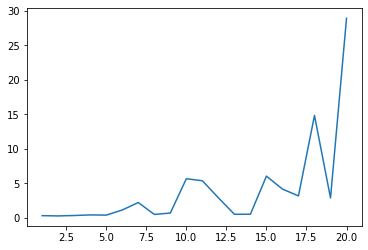

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
lst = [
[0.313706636428833, 1],
[0.27654528617858887, 2],
[0.3341958522796631, 3],
[0.42417049407958984, 4],
[0.3909618854522705, 5],
[1.1354515552520752, 6],
[2.2182183265686035, 7],
[0.4938480854034424, 8],
[0.6925902366638184, 9],
[5.664339780807495, 10],
[5.3716912269592285, 11],
[2.9044711589813232, 12],
[0.5131118297576904, 13],
[0.5233206748962402, 14],
[6.041232347488403, 15],
[4.1668541431427, 16],
[3.1761691570281982, 17],
[14.835201740264893, 18],
[2.882321357727051, 19],
[28.917636394500732, 20]]

time = [i[0] for i in lst]
core = [i[1] for i in lst]
plt.plot(core,time)



TypeError: ignored

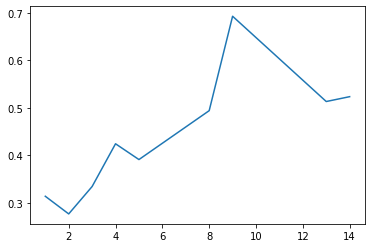

In [ ]:
# remove outliers
n_lst = [i for i in lst if i[0]>0 and i[0]<1]
time1 = [i[0] for i in n_lst]
core1 = [i[1] for i in n_lst]
plt.plot(core1,time1)

In [ ]:
https://stackoverflow.com/questions/6068236/reasons-of-sub-linear-speedup-in-parallel-programs

# Q2a

In [ ]:
z_mat = np.zeros((10, 100))
len(z_mat[0][0])

100

In [ ]:

from numba.pycc import CC

# name of compiled module to create:
cc = CC('q2a_aot')

# name of function in module, with explicit data types required (4byte=32bit ints and floats)
@cc.export('calc_p', 'f8[:,:](i8,i8,f8[:,:],f8,f8,f8,f8[:,:])')
def calc_p(z_mat):
    l_p = []
    for r in range(len(z_mat[0])):
        per_round = [t for t in range(len(z_mat)) if z_mat[t][r] > 0]
        np = len(per_round)
        l_p.append(np)

    avg = sum(l_p)/len(l_p)
    
    return avg

cc.compile()

In [ ]:
import numpy as np
from numba.pycc import CC

cc = CC('q2_aot')

# name of function in module, with explicit data types required (4byte=32bit ints and floats)
@cc.export('calc_p', 'f8(f8[:,:])')
def calc_p(z_mat):
    num = 0
    n_neg = 0
    for r in range(len(z_mat[0])): # iterating thru the number of running
        n=0
        for t in range(len(z_mat)):# iterating thru the periods of running
            if z_mat[t][r] <= 0:
                n = t
                n_neg += 1
                break
        num += n
    avg = num/n_neg
    return avg

cc.compile()

In [ ]:
rrrr = calc_p(z)
rrrr[1]

rrrr[0][1]
bs = [i for i in rrrr[0] if i[2]<=0 and i[3]> 0]

In [ ]:
sum([i[0] for i in rrrr[0]])/len(bs)

210.303

In [ ]:
%%writefile best_rho.py 
from mpi4py import MPI
import numpy as np
import q1a_aot
import q2_aot
import scipy.stats as sts
import time
import matplotlib.pyplot as plt
import pickle



def best_rho(n_runs=1000):
    t0 = time.time()
    # Set model parameters
    step = 0.95*2/200
    rho_arr = np.arange(-0.95,0.95, step)
    mu = 3.0
    sigma = 1.0
    z_0 = mu - 3*sigma
    # Set simulation parameters, draw all idiosyncratic random shocks,
    # and create empty containers
    S = n_runs # Set the number of lives to simulate
    T = int(4160) # Set the number of periods for each simulation
    np.random.seed(0)
    eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))

    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    name = MPI.Get_processor_name()

    if rank == 0:
      r_arr = rho_arr[0:20]
    else:
      r_arr = rho_arr[rank*20:(rank+1)*20]
    z_mat = np.zeros((T, S))
    l_r = []
    l_p = []
    for rho in r_arr:
        z=q1a_aot.gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat)
        avg = q2_aot.calc_p(z)
        l_r.append(rho)
        l_p.append(avg)

    r_ary = np.array(l_r)
    p_ary = np.array(l_p)

    recv1 = None
    recv2=None
    if rank == 0:
          recv1 = np.empty([size*20,1],dtype='float')
          recv2 = np.empty([size*20,1],dtype='float')
    comm.Gather(sendbuf = r_ary, recvbuf = recv1, root = 0) #reduce maxloc?
    comm.Gather(sendbuf = p_ary, recvbuf = recv2, root = 0)

    b_rho = None
    if rank == 0:
        for i in range(200):
            if recv2[i]==max(recv2):
                b_rho = recv1[i]
                print('rho:')
                print(float(b_rho[0]))
                print(recv2[i])
        dt = time.time()-t0
        print(float(dt))
        r1 = pickle.dumps(recv1)
        r2 = pickle.dumps(recv2)
        print([float(i[0]) for i in recv1])
        print([float(i[0]) for i in recv2])
    

    return

def main():
    best_rho(n_runs=1000)

if __name__ == '__main__':
    main()


Overwriting best_rho.py


In [ ]:
!mpirun --allow-run-as-root -n 10 python3 best_rho.py

rho:
0.00949999999999529
[734.70883534]
12.037683010101318
[-0.95, -0.9405, -0.931, -0.9215000000000001, -0.9120000000000001, -0.9025000000000002, -0.8930000000000002, -0.8835000000000003, -0.8740000000000003, -0.8645000000000004, -0.8550000000000004, -0.8455000000000005, -0.8360000000000005, -0.8265000000000006, -0.8170000000000006, -0.8075000000000007, -0.7980000000000007, -0.7885000000000008, -0.7790000000000008, -0.7695000000000008, -0.7600000000000009, -0.7505000000000009, -0.741000000000001, -0.731500000000001, -0.7220000000000011, -0.7125000000000011, -0.7030000000000012, -0.6935000000000012, -0.6840000000000013, -0.6745000000000013, -0.6650000000000014, -0.6555000000000014, -0.6460000000000015, -0.6365000000000015, -0.6270000000000016, -0.6175000000000016, -0.6080000000000017, -0.5985000000000017, -0.5890000000000017, -0.5795000000000018, -0.5700000000000018, -0.5605000000000019, -0.5510000000000019, -0.541500000000002, -0.532000000000002, -0.5225000000000021, -0.51300000000000

In [ ]:
l_r = [-0.95, -0.9405, -0.931, -0.9215000000000001, -0.9120000000000001, -0.9025000000000002, -0.8930000000000002, -0.8835000000000003, -0.8740000000000003, -0.8645000000000004, -0.8550000000000004, -0.8455000000000005, -0.8360000000000005, -0.8265000000000006, -0.8170000000000006, -0.8075000000000007, -0.7980000000000007, -0.7885000000000008, -0.7790000000000008, -0.7695000000000008, -0.7600000000000009, -0.7505000000000009, -0.741000000000001, -0.731500000000001, -0.7220000000000011, -0.7125000000000011, -0.7030000000000012, -0.6935000000000012, -0.6840000000000013, -0.6745000000000013, -0.6650000000000014, -0.6555000000000014, -0.6460000000000015, -0.6365000000000015, -0.6270000000000016, -0.6175000000000016, -0.6080000000000017, -0.5985000000000017, -0.5890000000000017, -0.5795000000000018, -0.5700000000000018, -0.5605000000000019, -0.5510000000000019, -0.541500000000002, -0.532000000000002, -0.5225000000000021, -0.5130000000000021, -0.5035000000000022, -0.4940000000000022, -0.48450000000000226, -0.4750000000000023, -0.46550000000000236, -0.4560000000000024, -0.44650000000000245, -0.4370000000000025, -0.42750000000000254, -0.4180000000000026, -0.40850000000000264, -0.3990000000000027, -0.38950000000000273, -0.3800000000000028, -0.3705000000000028, -0.3610000000000029, -0.3515000000000029, -0.34200000000000297, -0.332500000000003, -0.32300000000000306, -0.3135000000000031, -0.30400000000000316, -0.2945000000000032, -0.28500000000000325, -0.2755000000000033, -0.26600000000000334, -0.2565000000000034, -0.24700000000000344, -0.23750000000000349, -0.22800000000000353, -0.21850000000000358, -0.20900000000000363, -0.19950000000000367, -0.19000000000000372, -0.18050000000000377, -0.17100000000000382, -0.16150000000000386, -0.1520000000000039, -0.14250000000000396, -0.133000000000004, -0.12350000000000405, -0.1140000000000041, -0.10450000000000415, -0.09500000000000419, -0.08550000000000424, -0.07600000000000429, -0.06650000000000433, -0.05700000000000438, -0.04750000000000443, -0.038000000000004475, -0.02850000000000452, -0.01900000000000457, -0.009500000000004616, -4.6629367034256575e-15, 0.00949999999999529, 0.018999999999995243, 0.028499999999995196, 0.03799999999999515, 0.0474999999999951, 0.056999999999995055, 0.0664999999999949, 0.07599999999999496, 0.08549999999999502, 0.09499999999999487, 0.10449999999999471, 0.11399999999999477, 0.12349999999999484, 0.13299999999999468, 0.14249999999999452, 0.15199999999999458, 0.16149999999999465, 0.1709999999999945, 0.18049999999999433, 0.1899999999999944, 0.19949999999999446, 0.2089999999999943, 0.21849999999999414, 0.2279999999999942, 0.23749999999999427, 0.2469999999999941, 0.25649999999999396, 0.265999999999994, 0.2754999999999941, 0.2849999999999939, 0.29449999999999377, 0.30399999999999383, 0.3134999999999939, 0.32299999999999374, 0.3324999999999936, 0.34199999999999364, 0.3514999999999937, 0.36099999999999355, 0.3704999999999934, 0.37999999999999345, 0.3894999999999935, 0.39899999999999336, 0.4084999999999932, 0.41799999999999327, 0.42749999999999333, 0.43699999999999317, 0.446499999999993, 0.4559999999999931, 0.46549999999999314, 0.474999999999993, 0.4844999999999928, 0.4939999999999929, 0.503499999999993, 0.5129999999999928, 0.5224999999999926, 0.5319999999999927, 0.5414999999999928, 0.5509999999999926, 0.5604999999999924, 0.5699999999999925, 0.5794999999999926, 0.5889999999999924, 0.5984999999999923, 0.6079999999999923, 0.6174999999999924, 0.6269999999999922, 0.6364999999999921, 0.6459999999999921, 0.6554999999999922, 0.664999999999992, 0.6744999999999919, 0.683999999999992, 0.693499999999992, 0.7029999999999919, 0.7124999999999917, 0.7219999999999918, 0.7314999999999918, 0.7409999999999917, 0.7504999999999915, 0.7599999999999916, 0.7694999999999916, 0.7789999999999915, 0.7884999999999913, 0.7979999999999914, 0.8074999999999914, 0.8169999999999913, 0.8264999999999911, 0.8359999999999912, 0.8454999999999913, 0.8549999999999911, 0.8644999999999909, 0.873999999999991, 0.8834999999999911, 0.8929999999999909, 0.9024999999999908, 0.9119999999999908, 0.9214999999999909, 0.9309999999999907, 0.9404999999999906]


len(l_r)

200

In [ ]:
l_p = [9.441, 10.064, 10.795, 11.99, 13.555, 14.737, 15.971, 17.184, 18.511, 19.627, 21.499, 23.41, 25.885, 28.193, 29.846, 31.611, 33.805, 36.003, 39.082, 41.923, 45.53, 49.217, 53.062, 56.428, 60.252, 63.97, 67.724, 72.714, 78.136, 83.503, 88.724, 95.499, 102.164, 109.955, 117.47, 120.668, 127.325, 133.753, 139.918, 145.824, 152.003, 156.023, 162.644, 171.633, 183.027, 188.811, 199.401, 212.253, 222.179, 233.758, 244.229, 259.297, 270.633, 286.889, 300.277, 307.441, 324.73, 333.267, 341.708, 354.289, 368.114, 387.798, 395.71, 407.195, 415.181, 424.882, 435.995, 450.83, 462.844, 478.53553553553553, 492.13213213213214, 500.3793793793794, 525.8947895791583, 539.4208416833667, 557.4208416833667, 564.8917835671342, 579.2625250501002, 587.1513026052104, 599.9288577154308, 609.5661322645291, 626.185370741483, 636.7945891783567, 647.0831663326653, 653.7274549098196, 668.687374749499, 675.683366733467, 681.9789579158316, 689.0741482965932, 693.9158316633267, 699.628256513026, 705.9959919839679, 710.9177532597794, 712.0723618090452, 710.8569989929507, 718.6384692849949, 725.520644511581, 724.527693856999, 722.7072434607646, 726.6344410876133, 732.2462311557789, 732.1989949748744, 734.7088353413654, 721.8281407035175, 721.0713567839196, 722.6234939759037, 722.2961847389558, 717.3363453815261, 710.5486459378135, 709.9007021063189, 697.5105315947843, 689.0050100200401, 689.2364729458918, 685.2274549098196, 680.8398398398398, 662.4344344344345, 652.4294294294294, 647.7777777777778, 639.4694694694695, 627.5535535535536, 613.5205205205206, 607.4534534534534, 602.1041041041041, 591.1831831831831, 581.4114114114114, 576.065, 565.34, 547.821, 536.313, 526.785, 516.704, 505.401, 495.802, 482.333, 469.607, 460.38, 442.687, 431.482, 417.33, 406.471, 394.384, 382.804, 366.399, 351.028, 335.761, 324.341, 309.207, 301.99, 289.975, 281.264, 266.772, 253.2, 242.485, 237.598, 227.083, 218.228, 207.672, 194.426, 183.377, 166.847, 161.212, 155.007, 148.797, 141.852, 135.381, 129.055, 121.298, 113.759, 106.934, 100.374, 95.868, 90.986, 87.454, 82.323, 78.339, 75.24, 70.58, 66.472, 62.578, 58.654, 56.232, 52.443, 48.025, 44.459, 41.761, 38.822, 35.99, 33.365, 31.448, 29.188, 26.736, 24.358, 22.761, 21.55, 19.244, 18.461, 17.311, 16.452, 15.848, 15.005, 14.215]


len(l_p)

200

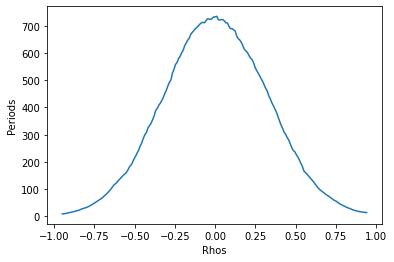

In [ ]:
import matplotlib.pyplot as plt

plt.plot(l_r,l_p)
plt.xlabel('Rhos')
plt.ylabel('Periods');

# Q3a

In [ ]:
! pip install --user rasterio
! pip install pyopencl mako

     |████████████████████████████████| 19.3 MB 1.9 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 879 kB 5.3 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=759b3e89d0ade0c4a8e248b7299c1f87c06c1f4602f41c7665c377c1344d1138
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pytools


In [ ]:
! export PATH=/root/.local/bin:$PATH

In [ ]:
pip install --user rasterio

In [ ]:
# Import required libraries
import rasterio
import numpy as np
# Import bands as separate images; in /project2/macs30123 on Midway2
band4 = rasterio.open('/content/LC08_B4.tif') #red
band5 = rasterio.open('/content/LC08_B5.tif') #nir
# Convert nir and red objects to float64 arrays
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')
# NDVI calculation
ndvi = (nir - red) / (nir + red)

ModuleNotFoundError: ignored

In [ ]:
import pyopencl as cl
import numpy as np

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

